[INFO] Starting utility vs R² pipeline for label: population
[INFO] Loading utilities CSV from: ../0_results/usavars/population/utilities.csv
[INFO] Utilities CSV loaded with 1044 rows
[INFO] Filtered merged_df to size ≤ 1000
Merged dataframe sampling types count:
sampling_type
cluster_sampling     360
convenience_urban    100
random_sampling      100
Name: count, dtype: int64
[INFO] Saved individual plot 1: ../0_results/usavars/population/plots/4_panel_r2_utility_scatterplot_population_1.png
[INFO] Saved individual plot 2: ../0_results/usavars/population/plots/4_panel_r2_utility_scatterplot_population_2.png
[INFO] Saved individual plot 3: ../0_results/usavars/population/plots/4_panel_r2_utility_scatterplot_population_3.png
[INFO] Saved individual plot 4: ../0_results/usavars/population/plots/4_panel_r2_utility_scatterplot_population_4.png
[INFO] Saved 4-panel plot: ../0_results/usavars/population/plots/4_panel_r2_utility_scatterplot_population.png


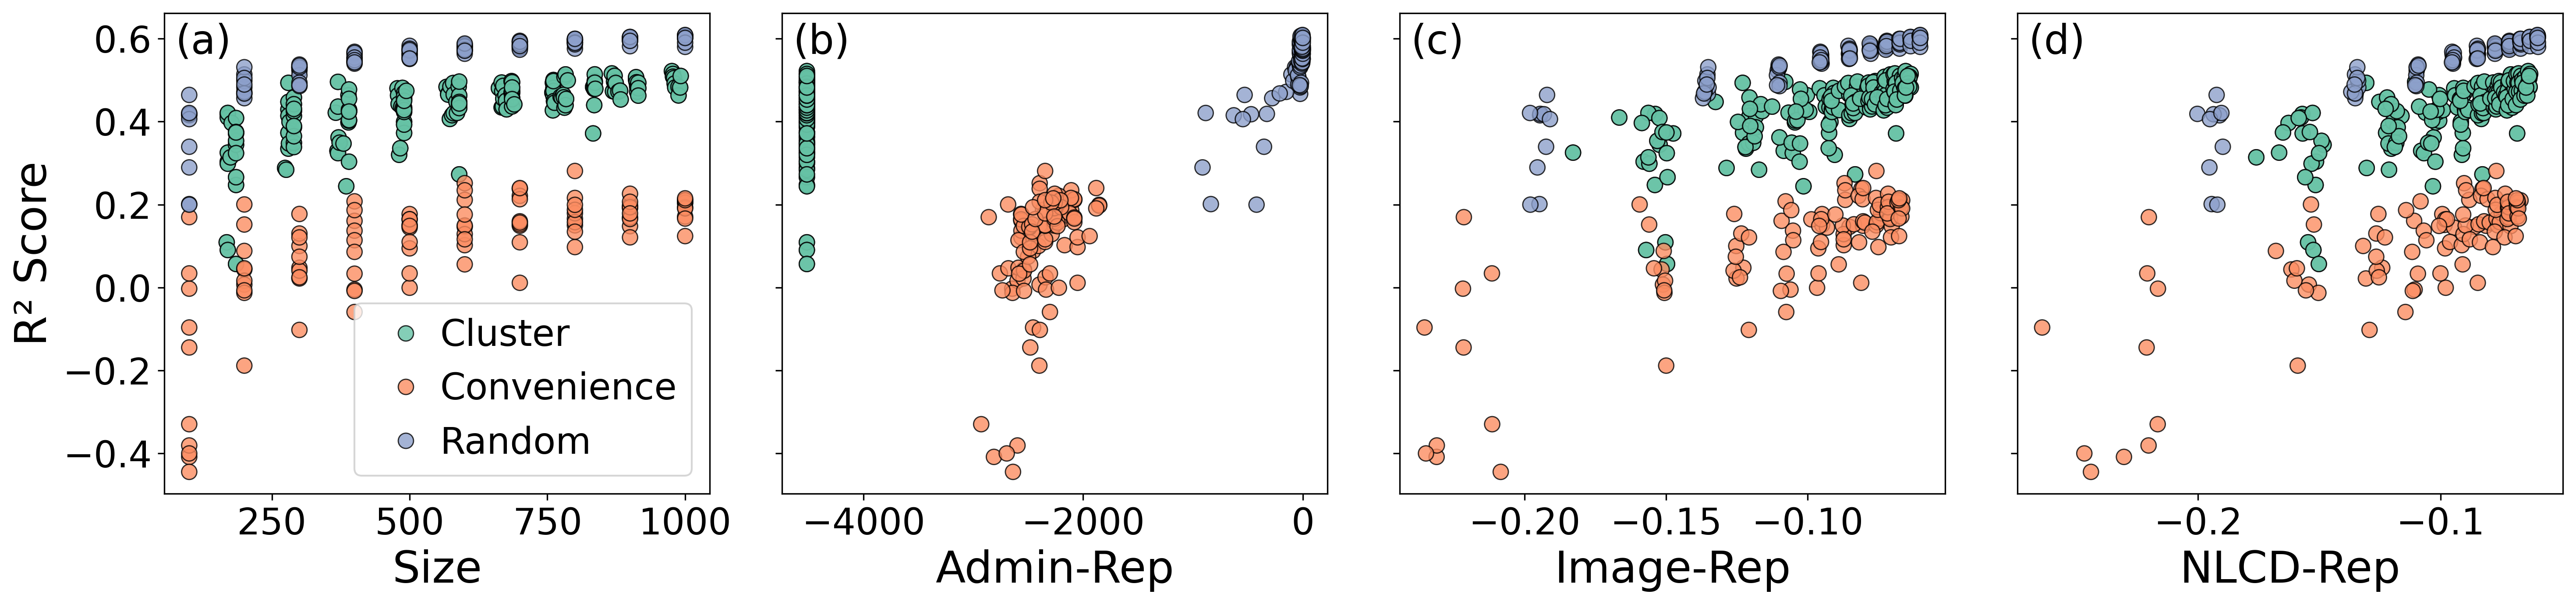


RHO VALUES TABLE (Spearman Correlation Coefficients)
      Sampling Type   Size Admin-Rep Image-Rep NLCD-Rep
            Unknown -0.127    -0.297    -0.017   -0.078
            Cluster  0.761     0.761     0.763    0.757
Convenience (Urban)  0.689     0.518     0.685    0.701
             Random  0.959     0.716     0.955    0.949
            Overall  0.321     0.521     0.682    0.684

LATEX TABLE FORMAT
\begin{table}[htbp]
\centering
\begin{tabular}{lcccc}
\toprule
\multirow{2}{*}{Sampling Type} & \multirow{2}{*}{Size} & \multicolumn{2}{c}{Admin-Rep} & \multicolumn{2}{c}{Image-Rep} & \multicolumn{2}{c}{NLCD-Rep}  \\
\cmidrule(lr){3-4}
 & & NLCD & Image & \\
\midrule
Unknown & -0.127 & -0.297 & -0.017 & -0.078 \\
Cluster & 0.761 & 0.761 & 0.763 & 0.757 \\
Convenience (Urban) & 0.689 & 0.518 & 0.685 & 0.701 \\
Random & 0.959 & 0.716 & 0.955 & 0.949 \\
\midrule
Overall & 0.321 & 0.521 & 0.682 & 0.684 \\
\bottomrule
\end{tabular}
\caption{Spearman correlation coefficients ($\rho$) betwe

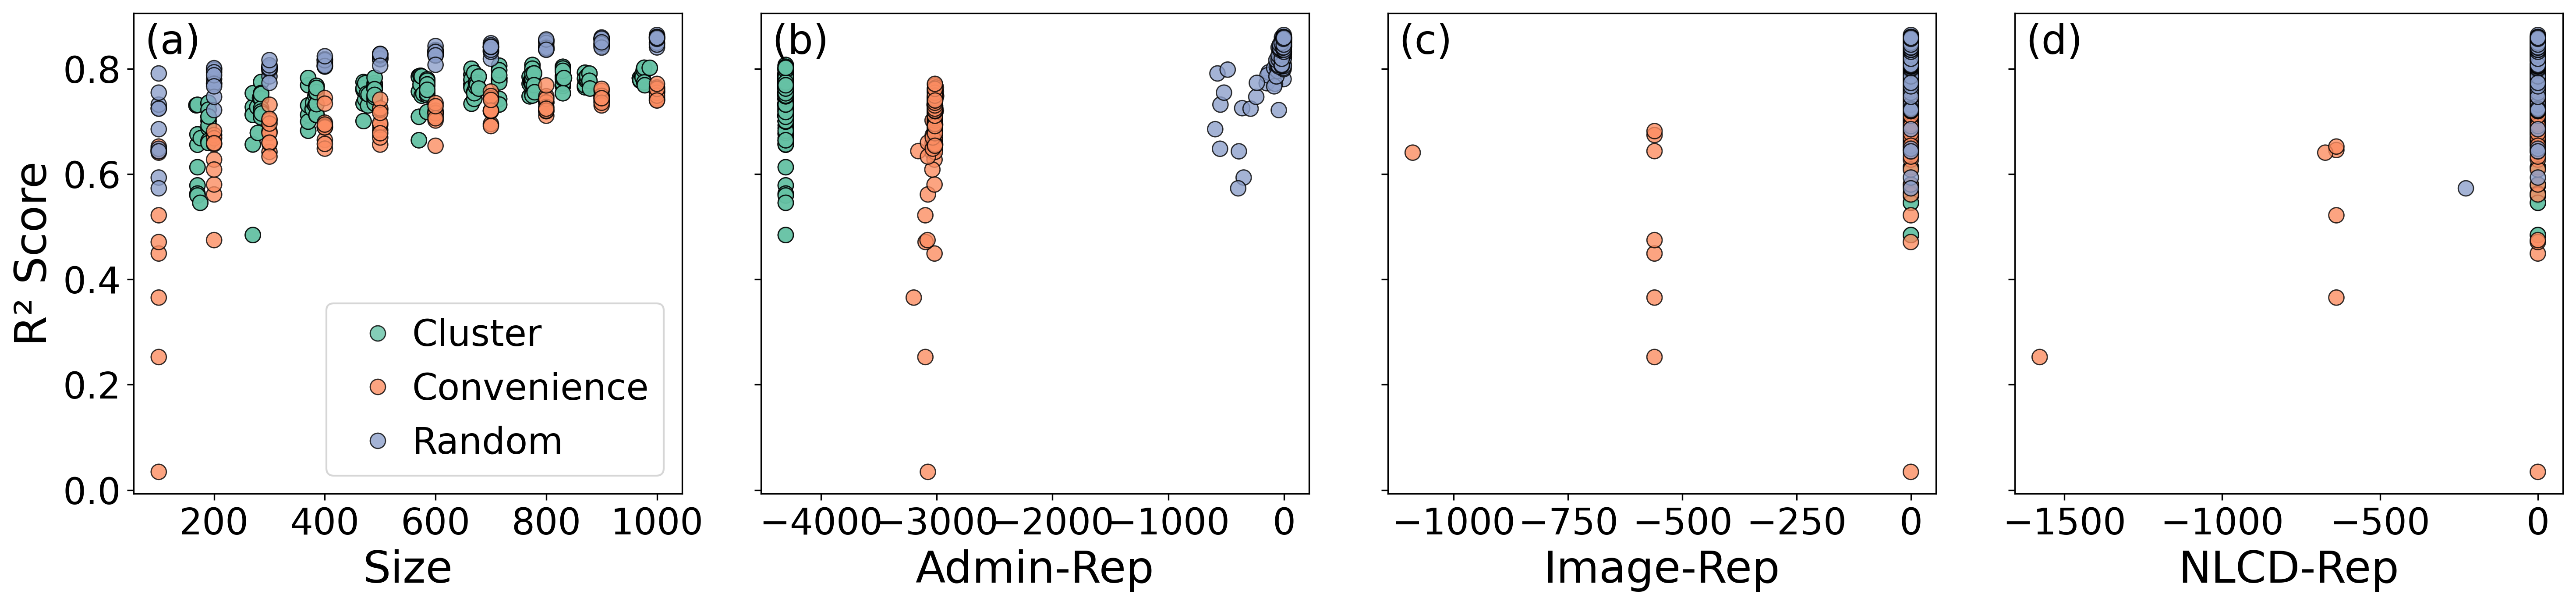


RHO VALUES TABLE (Spearman Correlation Coefficients)
      Sampling Type  Size Admin-Rep Image-Rep NLCD-Rep
            Cluster 0.761     0.762     0.771    0.759
Convenience (Urban) 0.870     0.828     0.843    0.872
             Random 0.959     0.773     0.963    0.953
            Overall 0.587     0.454     0.775    0.767

LATEX TABLE FORMAT
\begin{table}[htbp]
\centering
\begin{tabular}{lcccc}
\toprule
\multirow{2}{*}{Sampling Type} & \multirow{2}{*}{Size} & \multicolumn{2}{c}{Admin-Rep} & \multicolumn{2}{c}{Image-Rep} & \multicolumn{2}{c}{NLCD-Rep}  \\
\cmidrule(lr){3-4}
 & & NLCD & Image & \\
\midrule
Cluster & 0.761 & 0.762 & 0.771 & 0.759 \\
Convenience (Urban) & 0.870 & 0.828 & 0.843 & 0.872 \\
Random & 0.959 & 0.773 & 0.963 & 0.953 \\
\midrule
Overall & 0.587 & 0.454 & 0.775 & 0.767 \\
\bottomrule
\end{tabular}
\caption{Spearman correlation coefficients ($\rho$) between utility metrics and $R^2$ scores}
\label{tab:rho_values}
\end{table}

[INFO] LaTeX table saved to: ../0_r

In [ ]:
import glob
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

def refine_convenience_sampling_type(row):
    if row["base_sampling_type"] != "convenience_sampling":
        return row["base_sampling_type"]
    if "urban" in row["initial_set"]:
        return "convenience_urban"
    else:
        return

def refine_r2_sampling_type(row):
    if row["base_sampling_type"] != "convenience_sampling":
        return row["base_sampling_type"]
    if "urban" in row["initial_set"]:
        return "convenience_urban"
    else:
        return



def extract_base_sampling_type(long_sampling_type):
    for base_type in ["random_sampling", "convenience_sampling", "cluster_sampling"]:
        if long_sampling_type.startswith(base_type):
            return base_type
    return None


def load_utilities_csv(path):
    print(f"[INFO] Loading utilities CSV from: {path}")
    df = pd.read_csv(path)
    required_cols = ["initial_set", "sampling_type", "size"]
    for col in required_cols:
        if col not in df.columns:
            print(df.columns)
            raise ValueError(f"[ERROR] Missing required column in utilities CSV: {col}")
    print(f"[INFO] Utilities CSV loaded with {len(df)} rows")
    return df


def load_all_r2_scores(r2_dir):
    r2_files = glob.glob(os.path.join(r2_dir, "*_r2_scores.csv"))
    all_dfs = []
    print(f"[INFO] Found {len(r2_files)} R² score files in {r2_dir}")
    for path in r2_files:
        filename = os.path.basename(path)
        if not filename.endswith("_r2_scores.csv"):
            print(f"[WARNING] Skipping unexpected file: {filename}")
            continue
        sampling_type = filename.replace("_r2_scores.csv", "")
        print(f"[INFO] Loading R² scores for sampling_type: {sampling_type}")
        df = pd.read_csv(path)
        if "initial_set" not in df.columns or "r2" not in df.columns:
            print(
                f"[WARNING] Missing 'initial_set' or 'r2' columns in {filename}, skipping."
            )
            continue
        df["sampling_type"] = sampling_type
        all_dfs.append(df)
    if not all_dfs:
        raise RuntimeError(f"[ERROR] No valid R² score files loaded from {r2_dir}")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(
        f"[INFO] Loaded R² scores for {combined_df['sampling_type'].nunique()} sampling types, total rows: {len(combined_df)}"
    )
    return combined_df


def merge_utilities_with_r2(utilities_df, summaries_dir):
    # Step 1: Extract and then refine the base type
    utilities_df["base_sampling_type"] = utilities_df["sampling_type"].apply(extract_base_sampling_type)
    utilities_df["refined_sampling_type"] = utilities_df.apply(refine_convenience_sampling_type, axis=1)

    merged_parts = []

    # Group by the file-determining base type (e.g. convenience_sampling)
    groups = utilities_df.groupby(["base_sampling_type", "size"])

    for (base_sampling_type, sample_size), group_df in groups:
        summary_csv_path = os.path.join(summaries_dir, f"{base_sampling_type}_r2_scores.csv")
        if not os.path.exists(summary_csv_path):
            print(f"[Warning] Missing summary file: {summary_csv_path}")
            continue

        r2_df = pd.read_csv(summary_csv_path)
        r2_df_filtered = r2_df[r2_df["size"] == sample_size].copy()

        # Tag with base and refined types
        r2_df_filtered["base_sampling_type"] = base_sampling_type
        r2_df_filtered["refined_sampling_type"] = r2_df_filtered.apply(refine_r2_sampling_type, axis=1)

        # Drop the original sampling_type to avoid confusion
        group_df = group_df.drop(columns=["sampling_type"])
        
        merged = group_df.merge(
            r2_df_filtered,
            on=["initial_set", "size", "base_sampling_type", "refined_sampling_type"],
            how="inner",
        )
        merged_parts.append(merged)

    if not merged_parts:
        raise RuntimeError("No merged data. Check summary files and matching columns.")

    merged_df = pd.concat(merged_parts, ignore_index=True)

    # Rename for output clarity
    merged_df = merged_df.rename(columns={"refined_sampling_type": "sampling_type"})

    return merged_df



from scipy.stats import spearmanr
import numpy as np
import pandas as pd

def compute_rho_table(df, utility_cols, utility_labels, top_utility_only=False, quantile=0.50):
    """Compute a table of rho values for each sampling type and utility metric."""
    
    sampling_type_map = {
        "random_sampling": "Random",
        "convenience_urban": "Convenience (Urban)",
        #"convenience_region": "Convenience (Region)",
        #"convenience_other": "Convenience (Other)",
        "cluster_sampling": "Cluster",
    }

    # Apply top-X% filtering across all utility metrics
    if top_utility_only:
        thresholds = {col: df[col].quantile(quantile) for col in utility_cols}
        mask = np.ones(len(df), dtype=bool)
        for col in utility_cols:
            mask &= df[col] >= thresholds[col]
        df = df[mask].copy()
        print(f"[INFO] Computing rho table for top {int((1 - quantile) * 100)}% of samples across all utilities. n = {len(df)}")

    # Initialize the results dictionary
    results = {"Sampling Type": [], **{label: [] for label in utility_labels}}

    # Compute overall rhos
    overall_rhos = {}
    for utility_col, label in zip(utility_cols, utility_labels):
        if df[utility_col].nunique() > 1:
            overall_rho, _ = spearmanr(df[utility_col], df["r2"])
            overall_rhos[label] = f"{overall_rho:.3f}"
        else:
            overall_rhos[label] = "N/A"

    # Compute rhos per sampling type
    sampling_types = df["sampling_type"].fillna("Unknown").unique()
    for sampling_type in sorted(sampling_types):
        display_name = sampling_type_map.get(sampling_type, sampling_type)
        results["Sampling Type"].append(display_name)

        group = df[df["sampling_type"].fillna("Unknown") == sampling_type]
        for utility_col, label in zip(utility_cols, utility_labels):
            if group[utility_col].nunique() > 1:
                rho, _ = spearmanr(group[utility_col], group["r2"])
                results[label].append(f"{rho:.3f}")
            else:
                results[label].append("N/A")

    # Add overall row
    results["Sampling Type"].append("Overall")
    for label in utility_labels:
        results[label].append(overall_rhos[label])

    return pd.DataFrame(results)



def get_clean_labels(df):
    """Get clean sampling type labels without rho values."""
    sampling_type_map = {
        "random_sampling": "Random",
        "convenience_urban": "Convenience",
        #"convenience_region": "Convenience (Region)",
        #"convenience_other": "Convenience (Other)",
        "cluster_sampling": "Cluster",
    }


    labels = {}
    for name in df["sampling_type"].unique():
        labels[name] = sampling_type_map.get(name, name)
    return labels


def plot_4_panel_utility_vs_r2(df, utility_cols, labels, save_path=None, text_size=12, top_utility_only=False, quantile=0.50):
    """Create a 4-panel plot with utility vs R² for different metrics."""

    # Set font sizes
    plt.rcParams.update(
        {
            "font.size": text_size,
            "axes.labelsize": text_size,
            "axes.titlesize": text_size,
            "xtick.labelsize": text_size,
            "ytick.labelsize": text_size,
            "legend.fontsize": text_size,
        }
    )

    if top_utility_only:
        thresholds = {col: df[col].quantile(quantile) for col in utility_cols}
        mask = np.ones(len(df), dtype=bool)
        for col in utility_cols:
            mask &= df[col] >= thresholds[col]
        df = df[mask].copy()
        print(f"[INFO] Filtered to top 10% across all utility metrics, n = {len(df)}")

    fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=300)

    panel_labels = ["(a)", "(b)", "(c)", "(d)"]

    clean_labels = get_clean_labels(df)
    df["sampling_type_clean"] = df["sampling_type"].map(clean_labels)

    for idx, (utility_col, label) in enumerate(zip(utility_cols, labels)):
        ax = axes[idx]

        # Plot on the 4-panel subplot
        sns.scatterplot(
            data=df,
            x=utility_col,
            y="r2",
            hue="sampling_type_clean",
            palette="Set2",
            s=70,
            alpha=0.8,
            edgecolor="k",
            ax=ax,
            legend=(idx == 0),
        )

        ax.set_xlabel(label, fontsize=text_size + 4)
        ax.set_ylabel("R² Score" if idx == 0 else "", fontsize=text_size + 4)

        ax.text(
            0.02, 0.98, panel_labels[idx], transform=ax.transAxes,
            fontsize=text_size + 2, va="top", ha="left"
        )

        if idx == 0:
            ax.legend(
                title=None,
                fontsize=text_size,
                loc="lower right",
                handletextpad=-0.05,
            )
        else:
            ax.set_yticklabels([])

        # Create individual figure for this plot
        fig_i, ax_i = plt.subplots(figsize=(5, 5), dpi=300)

        sns.scatterplot(
            data=df,
            x=utility_col,
            y="r2",
            hue="sampling_type_clean",
            palette="Set2",
            s=70,
            alpha=0.8,
            edgecolor="k",
            ax=ax_i,
            legend=(idx == 0),
        )

        ax_i.set_xlabel(label, fontsize=text_size + 4)
        ax_i.set_ylabel("R² Score" if idx == 0 else "", fontsize=text_size + 4)

        ax_i.text(
            0.02, 0.98, panel_labels[idx], transform=ax_i.transAxes,
            fontsize=text_size + 2, va="top", ha="left"
        )

        if idx == 0:
            ax_i.legend(
                title=None,
                fontsize=text_size,
                loc="lower right",
                handletextpad=-0.05,
            )
        else:
            ax_i.set_yticklabels([])

        # Show or save the individual figure here:
        if save_path:
            # For example, save each individual figure with a different name
            individual_path = save_path.replace(".png", f"_{idx+1}.png")
            fig_i.savefig(individual_path, bbox_inches="tight")
            print(f"[INFO] Saved individual plot {idx+1}: {individual_path}")
            plt.close(fig_i)  # Close after saving to free memory
        else:
            fig_i.show()  # Show individual figure

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"[INFO] Saved 4-panel plot: {save_path}")
    else:
        fig.show()  # Show combined figure
    plt.show()

    # Reset font sizes to default
    plt.rcParams.update(plt.rcParamsDefault)



def print_latex_table(rho_df, save_path=None):
    """Print the rho table in a format ready for LaTeX with Risk as a super column."""

    print("\n" + "=" * 80)
    print("RHO VALUES TABLE (Spearman Correlation Coefficients)")
    print("=" * 80)
    print(rho_df.to_string(index=False))

    print("\n" + "=" * 80)
    print("LATEX TABLE FORMAT")
    print("=" * 80)

    # Create LaTeX table
    latex_lines = []
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append("\\begin{tabular}{lcccc}")
    latex_lines.append("\\toprule")

    # First header row with multicolumn for Risk
    latex_lines.append(
        "\\multirow{2}{*}{Sampling Type} & \\multirow{2}{*}{Size} & \\multicolumn{2}{c}{Admin-Rep} & \\multicolumn{2}{c}{Image-Rep} & \\multicolumn{2}{c}{NLCD-Rep}  \\\\"
    )
    latex_lines.append("\\cmidrule(lr){3-4}")

    # Second header row with NLCD and Image
    latex_lines.append(" & & NLCD & Image & \\\\")
    latex_lines.append("\\midrule")

    # Data rows
    for idx, row in rho_df.iterrows():
        if row["Sampling Type"] == "Overall":
            latex_lines.append("\\midrule")

        # Extract values based on column names
        sampling_type = row["Sampling Type"]
        size = row["Size"]
        nlcd = row["NLCD-Rep"]
        image = row["Image-Rep"]
        admin = row["Admin-Rep"]

        row_str = f"{sampling_type} & {size} & {admin} & {image} & {nlcd} \\\\"
        latex_lines.append(row_str)

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")
    latex_lines.append(
        "\\caption{Spearman correlation coefficients ($\\rho$) between utility metrics and $R^2$ scores}"
    )
    latex_lines.append("\\label{tab:rho_values}")
    latex_lines.append("\\end{table}")

    latex_table = "\n".join(latex_lines)
    print(latex_table)

    if save_path:
        with open(save_path, "w") as f:
            f.write(latex_table)
        print(f"\n[INFO] LaTeX table saved to: {save_path}")

    return latex_table


def run_utility_r2_pipeline(
    dir, label, utilities_csv_path, r2_dir, utility_cols, utility_labels, text_size=12, max_size=None, top_utility_only=False
):
    print(f"[INFO] Starting utility vs R² pipeline for label: {label}")

    utilities_df = load_utilities_csv(utilities_csv_path)
    merged_df = merge_utilities_with_r2(utilities_df, dir)

    if max_size is not None and "size" in merged_df.columns:
        merged_df = merged_df[merged_df["size"] <= max_size]
        print(f"[INFO] Filtered merged_df to size ≤ {max_size}")

    print("Merged dataframe sampling types count:")
    print(merged_df["sampling_type"].value_counts())

    # Create the 4-panel plot
    plot_4_panel_utility_vs_r2(
        merged_df,
        utility_cols=utility_cols,
        labels=utility_labels,
        save_path=os.path.join(
            r2_dir, f"plots/4_panel_r2_utility_scatterplot_{label}.png"
        ),
        text_size=text_size,
        top_utility_only=top_utility_only
    )

    # Compute and print rho table
    rho_df = compute_rho_table(merged_df, utility_cols, utility_labels, top_utility_only=top_utility_only)
    latex_table_path = os.path.join(r2_dir, f"plots/rho_table_{label}.tex")
    print_latex_table(rho_df, save_path=latex_table_path)

    print(f"[INFO] Completed utility vs R² pipeline for label: {label}")


if __name__ == "__main__":
    # Define the utility metrics and their labels
    utility_metrics = [
        "size",
        "pop_risk_states_0.5",  # Using this as diversity metric
        "pop_risk_image_clusters_8_0.5",
        "pop_risk_nlcd_0.5"]

    utility_labels = [
        "Size",
        "Admin-Rep",
        "Image-Rep",
        "NLCD-Rep",
    ]

    # You can adjust the text size here
    text_size = 20

    for label in ["population", "treecover"]:
        base_dir = f"../0_results/usavars/{label}"
        utilities_csv = os.path.join(base_dir, "utilities.csv")
        r2_scores_dir = base_dir

        plots_dir = os.path.join(r2_scores_dir, "plots/top_50_percent")
        os.makedirs(plots_dir, exist_ok=True)

        summaries_dir = f"../0_results/usavars/{label}"

        run_utility_r2_pipeline(
            summaries_dir,
            label,
            utilities_csv,
            r2_scores_dir,
            utility_metrics,
            utility_labels,
            text_size=text_size,
            max_size=1000,
            top_utility_only=True
        )